[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/02_regresion_logistica.ipynb)

# Regresion Logística


Hablar que se uso la forma multiclass


## 1. Librerias y configuraciones previas


In [112]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
except ImportError:
    !pip install scipy

try:
    import imblearn
except ImportError:
    !pip install imblearn

In [113]:
# Determinacion si el archivo se va a ejecutar desde colab o local y configuracion de los elementos necesarios para la ejecucion
import sys
import os

# Path del notebook
notebook_path = "."
print(notebook_path)
try:
    import google.colab
    !git clone https://github.com/repos-especializacion-UdeA/trabajo-final_AA1.git
    %cd /content/trabajo-final_AA1/notebooks_pasos_previos   
    %pwd
    ruta_base = '/content/trabajo-final_AA1/notebooks_pasos_previos/'
    sys.path.append(ruta_base)
except ImportError:
    print("El notebook no se está ejecutando en Google Colab.")
    ruta_base = './'

.
El notebook no se está ejecutando en Google Colab.


In [193]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize

#Creación de modelo
from sklearn.linear_model import LogisticRegression

#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

## 2. Funciones

In [115]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones1 import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [155]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada

#Cargar el dataset
DATA_PATH = './datasets_tarea/'
d = pd.read_csv( DATA_PATH + 'db1_rms_prep.csv')

In [156]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16250 entries, 0 to 16249
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   16250 non-null  float64
 1   emg_2   16250 non-null  float64
 2   emg_3   16250 non-null  float64
 3   emg_4   16250 non-null  float64
 4   emg_5   16250 non-null  float64
 5   emg_6   16250 non-null  float64
 6   emg_7   16250 non-null  float64
 7   emg_8   16250 non-null  float64
 8   emg_9   16250 non-null  float64
 9   emg_10  16250 non-null  float64
 10  label   16250 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB


## 4. Visualización de datos

### Variables de entrada

In [157]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

""
0
1


In [162]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label
0,0.5161,0.5810,0.1738,0.0683,0.0316,0.0024,0.0024,0.0491,0.6086,0.0066,0
1,0.1238,0.2910,0.0074,0.0025,0.0024,0.0024,0.0024,0.0090,0.0026,0.0024,0


In [163]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('label')

### Variable de salida

In [164]:
# Distriución de la variable de salida

d.groupby('label').label.count().sort_values(ascending=False)

label
0     1250
1     1250
2     1250
3     1250
4     1250
5     1250
6     1250
7     1250
8     1250
9     1250
10    1250
11    1250
12    1250
Name: label, dtype: int64

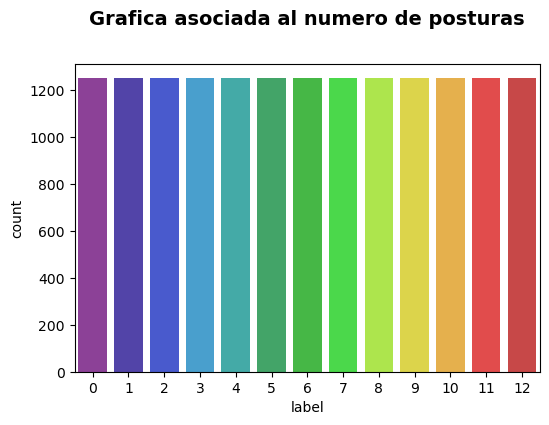

In [165]:
##Visualización de la variable de salida
multiple_plot(1, d , None, 'label', 'countplot', 'Grafica asociada al numero de posturas',0)

## 5. Transformación de datos

### Creación de variables Dummies 

In [166]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d = pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16250 entries, 0 to 16249
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   16250 non-null  float64
 1   emg_2   16250 non-null  float64
 2   emg_3   16250 non-null  float64
 3   emg_4   16250 non-null  float64
 4   emg_5   16250 non-null  float64
 5   emg_6   16250 non-null  float64
 6   emg_7   16250 non-null  float64
 7   emg_8   16250 non-null  float64
 8   emg_9   16250 non-null  float64
 9   emg_10  16250 non-null  float64
 10  label   16250 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB


## 6. Creación del modelo

### Dividir el conjunto de datos

In [167]:
#Se crea una lista con todas las varibles de entrada

vDep = list(d.columns)
vDep.remove('label')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='label')
y = d['label']

In [168]:
X.head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
0,0.5161,0.5810,0.1738,0.0683,0.0316,0.0024,0.0024,0.0491,0.6086,0.0066
1,0.1238,0.2910,0.0074,0.0025,0.0024,0.0024,0.0024,0.0090,0.0026,0.0024


In [169]:
y.head(2)

0    0
1    0
Name: label, dtype: int64

In [170]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [171]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'emg_10']


In [172]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_test[num_vars].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
8306,0.0006,0.0671,0.0209,0.0345,0.0197,0.0144,0.0738,0.2054,0.0429,0.2227
1455,0.0007,0.0677,0.0005,0.0006,0.0054,0.1176,0.1058,0.0416,0.0189,0.0680


### Creación del modelo

#### Creación y entrenamiento del modelo

https://realpython.com/logistic-regression-python/

**Parámetros importantes** 

- **multi_class**: 

    - `ovr` − (one-versus-rest) Para problemas de clasificación binaria.

    - `multimonial` − Para problemas de clasificación para más de 2 clases (multiclase).  No se puede usar si solver = ‘liblinear’.

    - `auto` − Esta opcion seleciona ‘ovr’ si solver = ‘liblinear’ o los datos son binarios sino elige ‘multinomial’.
    
    
- **solver**: 

    - `liblinear` - Muy eficiente con pequeños datasets. Solo se usa para problemas ovr (no trabaja con multiclases)
    
    - `lbfgs` (default) - Usualmente permite resolver la mayoría de las situaciones. Puede presentar dificultades con problemas de clasificación con conjuntos de datos grandes o muy grandes.
    - `newton-cg` , Puede ser computacionalmente muy costoso 
    - `sag` y `saga` - Muy eficientes con grandes datasets

https://holypython.com/log-reg/logistic-regression-optimization-parameters/


In [173]:
#Creación del modelo 

modelLRovrLinea = LogisticRegression(multi_class = "ovr"
                                     , solver='liblinear'
                                     , class_weight = 'balanced'
                                     , penalty='l2'
                                     , random_state=0) 

modelLRovrlbfgs = LogisticRegression(multi_class = "ovr" 
                                     , solver='lbfgs'
                                     , class_weight = 'balanced'
                                     , penalty='l2'
                                     , random_state=0)


modelLRMullbfgs = LogisticRegression(multi_class = "multinomial"
                                     , solver='lbfgs'
                                     , class_weight = 'balanced'
                                     , penalty='l2'
                                     , random_state=0)

modelLRMulnewton_cg = LogisticRegression(multi_class = "multinomial"
                                     , solver='newton-cg'
                                     , class_weight = 'balanced'
                                     , penalty='l2'
                                     , random_state=0)

#Entrenamiento del modelo con 80% de training

modelLRovrLinea.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=0,
                   solver='liblinear')

In [174]:
modelLRovrlbfgs.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=0)

In [175]:
modelLRMullbfgs.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=0)

In [176]:
modelLRMulnewton_cg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=0, solver='newton-cg')

### Evaluación del modelo

In [177]:
# Se realiza la predicción de cada uno de los modelos creados utilizando los datos prueba
y_predovrLinea = modelLRovrLinea.predict(X_test)
y_predovrlbfgs = modelLRovrlbfgs.predict(X_test)
y_predMullbfgs = modelLRMullbfgs.predict(X_test)
y_predMullnewton_cg = modelLRMulnewton_cg.predict(X_test)

#### Matriz de confusión y métricas

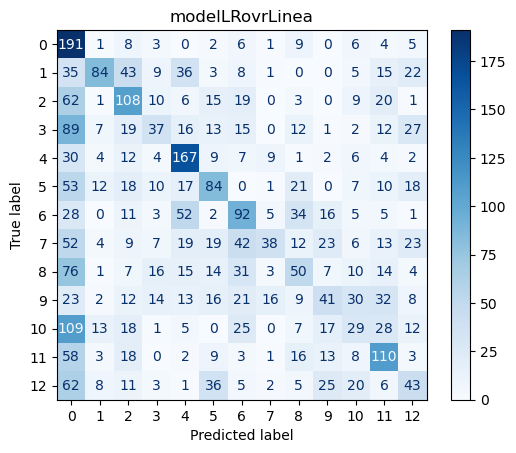

              precision    recall  f1-score   support

           0       0.22      0.81      0.35       236
           1       0.60      0.32      0.42       261
           2       0.37      0.43      0.39       254
           3       0.32      0.15      0.20       250
           4       0.48      0.65      0.55       257
           5       0.38      0.33      0.36       251
           6       0.34      0.36      0.35       254
           7       0.49      0.14      0.22       267
           8       0.28      0.20      0.23       248
           9       0.28      0.17      0.21       237
          10       0.20      0.11      0.14       264
          11       0.40      0.45      0.43       244
          12       0.25      0.19      0.22       227

    accuracy                           0.33      3250
   macro avg       0.35      0.33      0.31      3250
weighted avg       0.36      0.33      0.31      3250



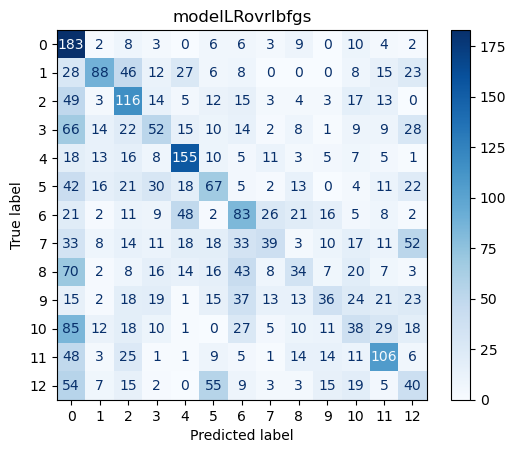

              precision    recall  f1-score   support

           0       0.26      0.78      0.39       236
           1       0.51      0.34      0.41       261
           2       0.34      0.46      0.39       254
           3       0.28      0.21      0.24       250
           4       0.51      0.60      0.55       257
           5       0.30      0.27      0.28       251
           6       0.29      0.33      0.31       254
           7       0.34      0.15      0.20       267
           8       0.25      0.14      0.18       248
           9       0.31      0.15      0.20       237
          10       0.20      0.14      0.17       264
          11       0.43      0.43      0.43       244
          12       0.18      0.18      0.18       227

    accuracy                           0.32      3250
   macro avg       0.32      0.32      0.30      3250
weighted avg       0.32      0.32      0.30      3250



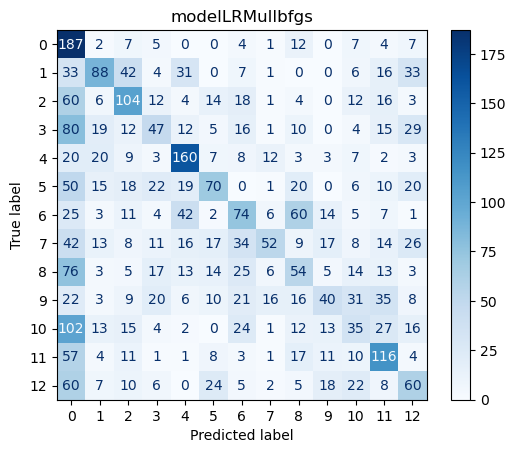

              precision    recall  f1-score   support

           0       0.23      0.79      0.36       236
           1       0.45      0.34      0.39       261
           2       0.40      0.41      0.40       254
           3       0.30      0.19      0.23       250
           4       0.52      0.62      0.57       257
           5       0.41      0.28      0.33       251
           6       0.31      0.29      0.30       254
           7       0.51      0.19      0.28       267
           8       0.24      0.22      0.23       248
           9       0.33      0.17      0.22       237
          10       0.21      0.13      0.16       264
          11       0.41      0.48      0.44       244
          12       0.28      0.26      0.27       227

    accuracy                           0.33      3250
   macro avg       0.35      0.34      0.32      3250
weighted avg       0.36      0.33      0.32      3250



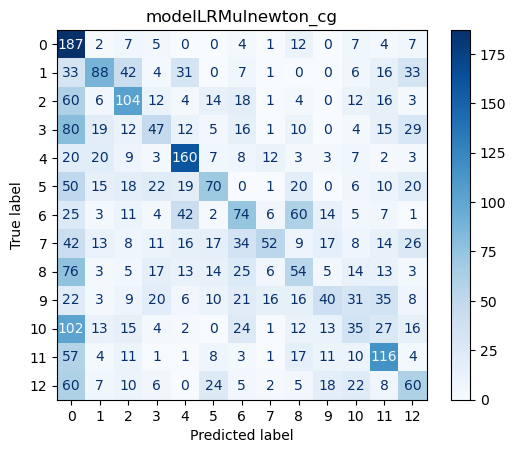

              precision    recall  f1-score   support

           0       0.23      0.79      0.36       236
           1       0.45      0.34      0.39       261
           2       0.40      0.41      0.40       254
           3       0.30      0.19      0.23       250
           4       0.52      0.62      0.57       257
           5       0.41      0.28      0.33       251
           6       0.31      0.29      0.30       254
           7       0.51      0.19      0.28       267
           8       0.24      0.22      0.23       248
           9       0.33      0.17      0.22       237
          10       0.21      0.13      0.16       264
          11       0.41      0.48      0.44       244
          12       0.28      0.26      0.27       227

    accuracy                           0.33      3250
   macro avg       0.35      0.34      0.32      3250
weighted avg       0.36      0.33      0.32      3250



In [178]:
# Crear un diccionario de modelos
models = {
    'modelLRovrLinea': [modelLRovrLinea, y_predovrLinea],
    'modelLRovrlbfgs': [modelLRovrlbfgs, y_predovrlbfgs],
    'modelLRMullbfgs': [modelLRMullbfgs, y_predMullbfgs],
    'modelLRMulnewton_cg': [modelLRMulnewton_cg, y_predMullnewton_cg]
}

# Para cada modelo se se extrae un elemento del diccionario models
for model_name, (model, y_pred) in models.items():
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Crear la visualización de la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    
    # Mostrar la visualización
    disp.plot(cmap='Blues')
    
    # Mostrar el título usando matplotlib
    plt.title(model_name)
    
    # Mostrar la figura
    plt.show()

    # Mostrar el informe de clasificación
    print(classification_report(y_test, y_pred))


#### ROC - Receiver Operating Characteristic

In [196]:
#Curva ROC para un modelo

fig = plt.figure(figsize=(10,6))

# Predecir las probabilidades de la clase positiva usando el modelo de regresión logística entrenado
probs = modelLRovrLinea.predict_proba(X_test)
# Tomar las probabilidades de la clase positiva solamente
probs = probs[:, 1]
print(probs.shape)
# Calcular el área bajo la curva ROC
#y_test = y_test.reshape(-1)
#print(y_test.shape)

classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
y_test_binarized = y_test_binarized.reshape(-1)
auc = roc_auc_score(y_test_binarized, probs, multi_class='ovr')
print(f"AUC multiclase: {auc}")

# auc = roc_auc_score(y_test, probs*1,multi_class='ovr')

# Imprimir el valor del AUC
# print('AUC: %.2f' % auc)

# Calcular la curva ROC usando los valores verdaderos y las probabilidades predichas
# fpr, tpr, thresholds = roc_curve(y_test, probs*(1))

# Graficar la curva ROC
# plot_roc_curve(fpr, tpr)


##Nota: es necesario que la variable de salida sea numérica, sino debe transformarse

(3250,)


ValueError: Expected 2D array, got 1D array instead:
array=[0.0295219  0.10604564 0.12416538 ... 0.05805195 0.02236447 0.08627864].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

<Figure size 1000x600 with 0 Axes>

### Guardar modelo

In [23]:
#Se guarda el modelo de Regresión logística
joblib.dump(modelLRovrLinea, './modelos/clasificacion/LR_Ret_ovrLineal.pkl')

['./modelos/clasificacion/LR_Ret_ovrLineal.pkl']

#### Referencias


- Regresion Logística

    - https://realpython.com/logistic-regression-python/#regularization
    
    
- Parámetros Regresion Logística 

    - https://holypython.com/log-reg/logistic-regression-optimization-parameters/


- *scikit-learn:*   
    - https://scikit-learn.org/stable/modules/svm.html



- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180



- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html